In [1]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import theano.tensor as tt
plt.rcParams["font.size"] = 30
sns.set(style='white', palette='deep', color_codes=True)

%matplotlib inline

# 実験データの作成

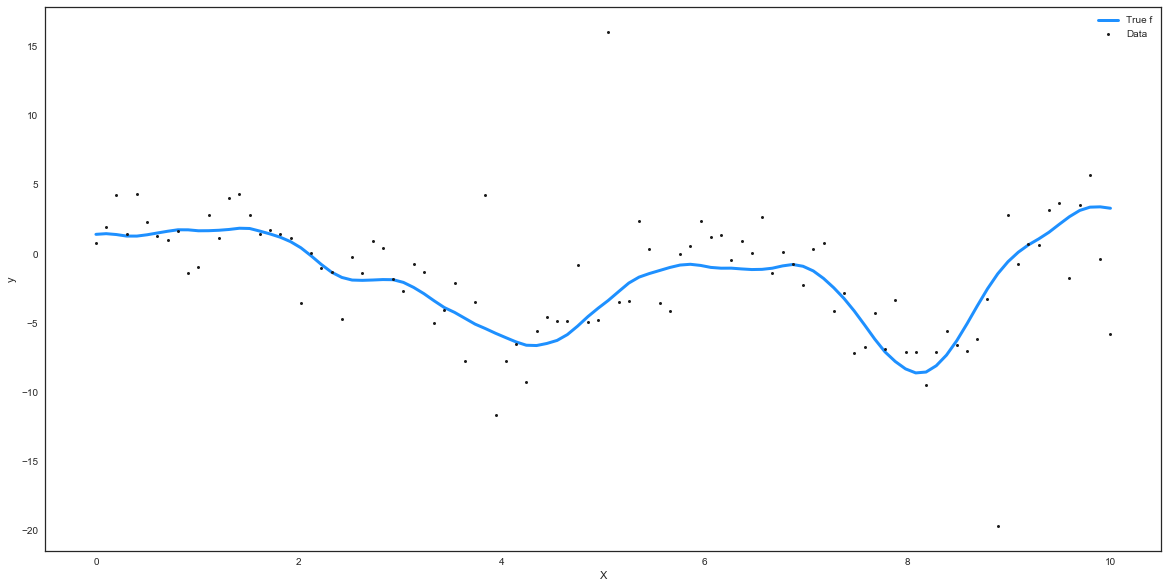

In [4]:
# set the seed
np.random.seed(1)

n = 100 # The number of data points
X = np.linspace(0, 10, n)[:, None] # The inputs to the GP, they must be arranged as a column vector
assert(X.shape == (n, 1)) # 行ベクトル

# 共分散行列の定義
ℓ_true = 1.0
η_true = 3.0
cov_func = η_true**2 * pm.gp.cov.Matern52(input_dim=1, ls=ℓ_true)
assert(cov_func(X).eval().shape == (n, n))

# 平均ベクトルの定義
mean_func = pm.gp.mean.Zero()
assert((n,) == mean_func(X).eval().shape)

# 多次元正規分布を作る。
f_true = np.random.multivariate_normal(
    # 平均ベクトル
    mean_func(X).eval(),
    
    # 共分散行列（計算を安定化させるため小さなノイズを意図的に載せる。
    cov_func(X).eval() + 1e-8*np.eye(n), 
    
    # n次元ベクトルを1つ作る。
    1) .flatten()
assert((100,) == f_true.shape)

# 上のガウス過程で得た値にノイズを載せる。
# このノイズはT分布に従う。
σ_true = 2.0
ν_true = 3.0
y = f_true + σ_true * np.random.standard_t(ν_true, size=n)

# 描画
fig = plt.figure(figsize=(20,10)); ax = fig.gca()
ax.plot(X, f_true, "dodgerblue", lw=3, label="True f");
ax.plot(X, y, 'ok', ms=3, label="Data");
ax.set_xlabel("X"); ax.set_ylabel("y"); plt.legend();

# GPによる解析

２つのグループのパラメータを推定したい。
- ガウス過程の共分散行列が持つパラメータ群
- 観測値=ガウス過程+ノイズで定義した。このノイズの確率分布が持つパラメータ群

これらのパラメータをベイズ推定する。

In [3]:
with pm.Model() as model:
    ℓ = pm.Gamma("ℓ", alpha=2, beta=1)
    η = pm.HalfCauchy("η", beta=5)

    cov = η**2 * pm.gp.cov.Matern52(1, ℓ)

    gp = pm.gp.Latent(cov_func=cov)

    f = gp.prior("f", X=X)

    σ = pm.HalfCauchy("σ", beta=5)
#     ν = pm.Gamma("ν", alpha=2, beta=0.1)
    y_ = pm.Normal("y", mu=f, sd=σ, observed=y)
#     y_ = pm.StudentT("y", mu=f, lam=1.0/σ, nu=ν, observed=y)

    trace = pm.sample(100)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [σ, f_rotated_, η, ℓ]
Sampling 2 chains: 100%|██████████| 1200/1200 [00:32<00:00, 37.41draws/s]
/Users/kumada/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/scipy/signal/signaltools.py:375: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  complex_result = (np.issubdtype(in1.dtype, complex) or
/Users/kumada/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/scipy/signal/signaltools.py:376: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  np.issubdtype(in2.dtype, complex))
There were 2 divergences after tuning. Increase `target_ac

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2ace0630>,
      dtype=object)

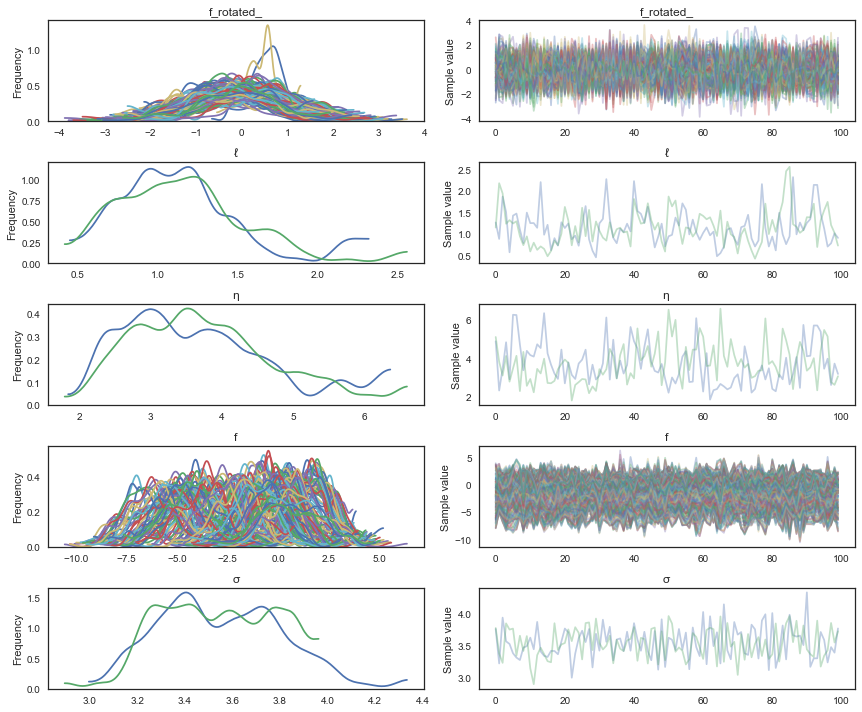

In [4]:
pm.traceplot(trace)

In [5]:
# 事後分布を描画する。
# pm.traceplot(trace, lines={"η": η_true, "σ": σ_true, "ℓ": ℓ_true, "ν": ν_true}, varnames=["η", "σ", "ℓ", "ν"]);

上の図において赤いラインは真の値である。

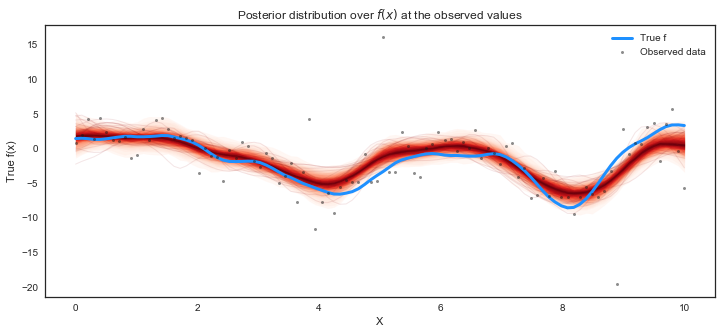

In [6]:
# plot the results
fig = plt.figure(figsize=(12,5)); 
ax = fig.gca()

# plot the samples from the gp posterior with samples and shading
# fの事後分布
from pymc3.gp.util import plot_gp_dist
plot_gp_dist(ax, trace["f"], X);

# plot the data and the true latent function
# ノイズを載せる前のf
plt.plot(X, f_true, "dodgerblue", lw=3, label="True f");
# 観測値
plt.plot(X, y, 'ok', ms=3, alpha=0.5, label="Observed data");

# axis labels and title
plt.xlabel("X"); plt.ylabel("True f(x)");
plt.title("Posterior distribution over $f(x)$ at the observed values"); plt.legend();


In [7]:
trace["f"][0]

array([ 4.00298726e+00,  3.75936621e+00,  3.55735074e+00,  3.30687967e+00,
        3.02395770e+00,  2.59617715e+00,  2.06108015e+00,  1.49169533e+00,
        9.99465181e-01,  5.72421927e-01,  2.36940072e-01, -3.68774670e-03,
       -2.28391586e-01, -4.98989373e-01, -7.03229870e-01, -7.25392643e-01,
       -5.89341420e-01, -4.45519954e-01, -4.03004225e-01, -4.64328564e-01,
       -5.08678835e-01, -4.58132892e-01, -2.05431837e-01,  1.40293215e-01,
        2.70352423e-01,  1.50990304e-01, -1.39704727e-01, -6.50703485e-01,
       -1.25918090e+00, -1.86105498e+00, -2.40186883e+00, -2.86994764e+00,
       -3.24160594e+00, -3.53694168e+00, -3.84956400e+00, -4.03095693e+00,
       -4.07664211e+00, -4.07596892e+00, -4.12133486e+00, -4.16425165e+00,
       -4.33627688e+00, -4.50658224e+00, -4.66804847e+00, -4.74469694e+00,
       -4.64906987e+00, -4.33019333e+00, -3.79360668e+00, -3.17431579e+00,
       -2.63973495e+00, -2.23823863e+00, -1.99436797e+00, -1.92112435e+00,
       -1.80330834e+00, -